In [1]:
%pip install kaggle --quiet
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

import zipfile
from pathlib import Path

zip_path = Path("news-headlines-dataset-for-sarcasm-detection.zip")
out_dir = Path("news-headlines-dataset-for-sarcasm-detection")

out_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path) as z:
    z.extractall(out_dir)

Note: you may need to restart the kernel to use updated packages.


Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)




  0%|          | 0.00/3.30M [00:00<?, ?B/s]
100%|██████████| 3.30M/3.30M [00:00<00:00, 1.42GB/s]


In [2]:
# Delete the zip file after successful extraction
if zip_path.exists():
    zip_path.unlink()
    print("Zip file deleted successfully.")
else:
    print("Zip file not found.")

Zip file deleted successfully.


In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

e:\Codes\ML\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
data_df = pd.read_json("news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(columns=["article_link"], inplace=True, axis=1)
print(data_df.shape)
data_df.head()

(26708, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(f"Training Size: {X_train.shape[0]}, Which is {round(X_train.shape[0]/data_df.shape[0]*100, 2)}%")
print(f"Validation Size: {X_val.shape[0]}, Which is {round(X_val.shape[0]/data_df.shape[0]*100, 2)}%")
print(f"Testing Size: {X_test.shape[0]}, Which is {round(X_test.shape[0]/data_df.shape[0]*100, 2)}%")

Training Size: 18695, Which is 70.0%
Validation Size: 4006, Which is 15.0%
Testing Size: 4007, Which is 15.0%


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 825.00it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [5]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x,
                            max_length=100,
                            truncation=True,
                            padding="max_length",
                            return_tensors="pt").to(device)
                            for x in X
                            ]
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [6]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

In [7]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class MyModel(nn.Module):
    def __init__(self, bert_model):
        super(MyModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)[0][:, 0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output
        

In [10]:
for param in bert_model.parameters():
    param.requires_grad = False
model = MyModel(bert_model).to(device)

In [11]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [12]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [27]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0
    for indx, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)

        prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
        loss = criterion(prediction, labels)
        total_loss_train += loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for indx, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs.to(device)
            labels.to(device)

            prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)
            loss = criterion(prediction, labels)
            total_loss_val += loss.item()

            acc = (prediction.round() == labels).sum().item()
            total_acc_val += acc
    
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/len(training_data)*100, 4))
    total_acc_val_plot.append(round(total_acc_val/len(validation_data)*100, 4))
    print(f"""
    Epoch: {epoch+1}/{EPOCHS} | 
    Train Loss: {round(total_loss_train/1000, 4)} | Train Accuracy: {round(total_acc_train/len(training_data)*100, 4)}%  
    Validation Loss: {round(total_loss_val/1000, 4)} | Validation Accuracy: {round(total_acc_val/len(validation_data)*100, 4)}%
    """)


    Epoch: 1/10 | 
    Train Loss: 0.1748 | Train Accuracy: 87.1998%  
    Validation Loss: 0.043 | Validation Accuracy: 85.3719%
    

    Epoch: 2/10 | 
    Train Loss: 0.1732 | Train Accuracy: 87.5528%  
    Validation Loss: 0.0435 | Validation Accuracy: 85.2721%
    

    Epoch: 3/10 | 
    Train Loss: 0.1732 | Train Accuracy: 87.3496%  
    Validation Loss: 0.0422 | Validation Accuracy: 85.8462%
    

    Epoch: 4/10 | 
    Train Loss: 0.1713 | Train Accuracy: 87.5903%  
    Validation Loss: 0.0426 | Validation Accuracy: 85.6465%
    

    Epoch: 5/10 | 
    Train Loss: 0.1714 | Train Accuracy: 87.4993%  
    Validation Loss: 0.0427 | Validation Accuracy: 85.6965%
    

    Epoch: 6/10 | 
    Train Loss: 0.1721 | Train Accuracy: 87.6972%  
    Validation Loss: 0.0421 | Validation Accuracy: 85.7464%
    

    Epoch: 7/10 | 
    Train Loss: 0.1703 | Train Accuracy: 87.8417%  
    Validation Loss: 0.0426 | Validation Accuracy: 85.5716%
    

    Epoch: 8/10 | 
    Train Loss: 0.17 |

In [28]:
with torch.no_grad():
    total_acc_test = 0
    for indx, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs.to(device)
        labels.to(device)

        prediction = model(inputs["input_ids"].squeeze(1), inputs["attention_mask"].squeeze(1)).squeeze(1)

        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc

print(f"Test Accuracy: {round(total_acc_test/len(testing_data)*100, 4)}%")

Test Accuracy: 85.0761%


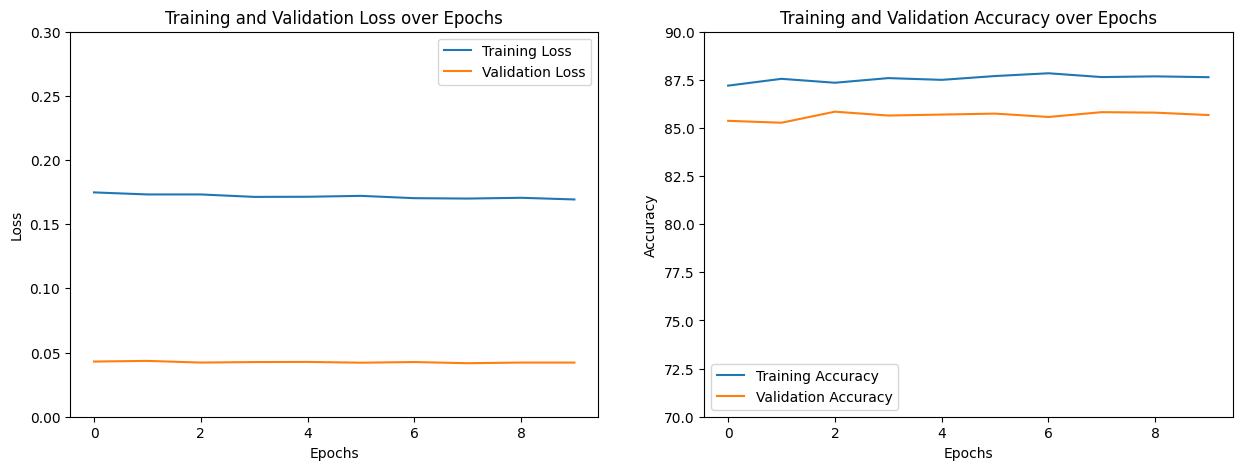

In [30]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotting loss over epochs
axis[0].plot(total_loss_train_plot, label="Training Loss")
axis[0].plot(total_loss_val_plot, label="Validation Loss")
axis[0].set_title("Training and Validation Loss over Epochs")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_ylim([0, 0.3])
axis[0].legend()

# Plotting accuracy over epochs
axis[1].plot(total_acc_train_plot, label="Training Accuracy")
axis[1].plot(total_acc_val_plot, label="Validation Accuracy")
axis[1].set_title("Training and Validation Accuracy over Epochs")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracy")
axis[1].set_ylim([70, 90])
axis[1].legend()

plt.show()